In [42]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# data loading and feature extaction

In [2]:
# load the csv as dataframe
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# create a graph from the dataframe
def create_graph(df):
    # Create the directed graph
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['fromnode'], row['tonode'], sign=row['sign'])
    return G

In [3]:
#degree features
def extract_degree_features(G, u, v):
    # Positive and negative outgoing degrees for u
    dout_pos_u= sum(1 for _, _, d in G.out_edges(u, data=True) if d['sign'] == 1)
    dout_neg_u= sum(1 for _, _, d in G.out_edges(u, data=True) if d['sign'] == -1)
    # Positive and negative incoming degrees for u
    din_pos_u= sum(1 for _, _, d in G.in_edges(u, data=True) if d['sign'] == 1)
    din_neg_u= sum(1 for _, _, d in G.in_edges(u, data=True) if d['sign'] == -1)

    # Positive and negative incoming degrees for v
    din_pos_v= sum(1 for _, _, d in G.in_edges(v, data=True) if d['sign'] == 1)
    din_neg_v= sum(1 for _, _, d in G.in_edges(v, data=True) if d['sign'] == -1)
    # Positive and negative outgoing degrees for v
    dout_pos_v= sum(1 for _, _, d in G.out_edges(v, data=True) if d['sign'] == 1)
    dout_neg_v= sum(1 for _, _, d in G.out_edges(v, data=True) if d['sign'] == -1)

    # Total degrees
    total_out_degree_u= dout_pos_u+ dout_neg_u
    total_in_degree_u = din_pos_u + din_neg_u
    total_in_degree_v= din_pos_v+ din_neg_v
    total_out_degree_v = dout_pos_v + dout_neg_v

    return [dout_pos_u, dout_neg_u, din_pos_u, din_neg_u, din_pos_v, din_neg_v, dout_pos_v, dout_neg_v, total_out_degree_u, total_in_degree_v,total_in_degree_u, total_out_degree_v]


# embeddedness feature
def calculate_embeddedness(G, u, v):
    # Undirected common neighbors
    common_neighbors = set(G.successors(u)).intersection(G.successors(v))
    return [len(common_neighbors)]


# clustering cofficient and eccentricity features
def extract_clustering_coefficient(G, u, v):
    # Clustering coefficient for u
    clustering_fromnode = nx.clustering(G, u)
    # Clustering coefficient for v
    clustering_v = nx.clustering(G, v)
    return [clustering_fromnode, clustering_v]

def extract_triad_features(G, u, v):
    # Initialize a 16-dimensional vector for triad counts
    triad_features = np.zeros(16, dtype=int)

    # Find neighbors of u and v
    neighbors_u = set(G.predecessors(u)).union(G.successors(u))
    neighbors_v = set(G.predecessors(v)).union(G.successors(v))
    common_neighbors = neighbors_u.intersection(neighbors_v)
    #print(f"Common Neighbors: {common_neighbors}")

    # Iterate over common neighbors
    for w in common_neighbors:
        if w == u or w == v:
            continue

        # Get edge signs and directions
        edges = [
            G.get_edge_data(u, w, default={'sign': 0}).get('sign', 0),
            G.get_edge_data(w, u, default={'sign': 0}).get('sign', 0),
            G.get_edge_data(v, w, default={'sign': 0}).get('sign', 0),
            G.get_edge_data(w, v, default={'sign': 0}).get('sign', 0),
        ]

        # Convert edge signs to binary (1 = positive, 0 = negative or no edge)
        edges_binary = [1 if e > 0 else 0 for e in edges]

        # Determine the index of the triad type
        triad_index = sum([edges_binary[i] * (2 ** i) for i in range(4)])
        triad_features[triad_index] += 1

    return list(triad_features)

In [4]:
#put all features of an edge to an array
def extract_features_for_edge(G, u, v):
    degree_features = extract_degree_features(G, u, v)
    embeddedness = calculate_embeddedness(G, u, v)
    clustering_coefficient = extract_clustering_coefficient(G, u, v)
    triad_features = extract_triad_features(G, u, v)

    # Combine into a single feature vector
    return degree_features+embeddedness+clustering_coefficient+triad_features

In [5]:
#extract features for all edges
def extract_features(G, df):
    X = []
    for _, row in df.iterrows():
        u = row['fromnode']
        v = row['tonode']
        X.append(extract_features_for_edge(G, u, v))
    return np.array(X)

# Dataset1 -- Bitcoin

In [6]:
# load the Bitcoin dataset
bitcoin_path = 'transformed_data_bitcoin.csv'
df_bitcoin = load_data(bitcoin_path)
G_bitcoin = create_graph(df_bitcoin)

In [53]:
# node count and edge count
print(f'Number of nodes: {G_bitcoin.number_of_nodes()}')
print(f'Number of edges: {G_bitcoin.number_of_edges()}')

Number of nodes: 3783
Number of edges: 24186


In [7]:
# extract features and labels
X = extract_features(G_bitcoin, df_bitcoin)
y = df_bitcoin['sign'].values

In [54]:
#check the shape of the dataset
print(X.shape)
print(y.shape)

#check the class distribution
print(df_bitcoin['sign'].value_counts())

#positive sign percentage
positive_sign_percentage = df_bitcoin['sign'].value_counts()[1] / len(df_bitcoin)
print(f'Positive sign percentage: {positive_sign_percentage}')

#negative sign percentage
negative_sign_percentage = df_bitcoin['sign'].value_counts()[-1] / len(df_bitcoin)
print(f'Negative sign percentage: {negative_sign_percentage}')

(24186, 31)
(24186,)
sign
 1    22650
-1     1536
Name: count, dtype: int64
Positive sign percentage: 0.9364921855618953
Negative sign percentage: 0.06350781443810469


In [9]:
# split the dataset into training and testing set
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
# train a logistic regression model
model_bitcoin = LogisticRegression()
model_bitcoin.fit(X_train, y_train)

/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
# evaluate the model using accuracy, f1 score, and confusion matrix
y_pred = model_bitcoin.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# f1 score
f1_scr = f1_score(y_test, y_pred)
print(f'F1 Score: {f1_scr}')

# confusion matrix
con_mtr = confusion_matrix(y_test, y_pred, labels=[1, -1])
print(f'Confusion Matrix: \n{con_mtr}')


Accuracy: 0.9491525423728814
F1 Score: 0.9732434196214923
Confusion Matrix: 
[[4474   51]
 [ 195  118]]


# Dataset2 -- Wikielect

In [12]:
#load the wiki data  and get rid of 0 sign values
wiki_path = 'wikielect.csv'
df_wiki = load_data(wiki_path)
df_wiki = df_wiki[df_wiki['sign'] != 0] # remove 0 sign values
G_wiki = create_graph(df_wiki)

In [19]:
# extract features and labels
X_wiki = extract_features(G_wiki, df_wiki)
y_wiki = df_wiki['sign'].values

In [20]:
#check the shape of the dataset
print(X_wiki.shape)
print(y_wiki.shape)

#check the class distribution
print(df_wiki['sign'].value_counts())

(107080, 31)
(107080,)
sign
 1    83962
-1    23118
Name: count, dtype: int64


In [21]:
# split the dataset into training and testing set
X_train_wiki, X_test_wiki, y_train_wiki, y_test_wiki = train_test_split(X_wiki, y_wiki, test_size=0.2, random_state=42, shuffle=True)

In [22]:
# train a logistic regression model
model_wiki = LogisticRegression()
model_wiki.fit(X_train_wiki, y_train_wiki)

/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
# evaluate the model using confusion matrix
y_pred_wiki = model_wiki.predict(X_test_wiki)

# accuracy
accuracy_wiki = accuracy_score(y_test_wiki, y_pred_wiki)
print(f'Accuracy: {accuracy_wiki}')

# f1 score
f1_scr_wiki = f1_score(y_test_wiki, y_pred_wiki)
print(f'F1 Score: {f1_scr_wiki}')

# confusion matrix
con_mtr_wiki = confusion_matrix(y_test_wiki, y_pred_wiki, labels=[1, -1])
print(f'Confusion Matrix: \n{con_mtr_wiki}')

Accuracy: 0.8621591333582368
F1 Score: 0.9137296159915834
Confusion Matrix: 
[[15633  1121]
 [ 1831  2831]]


# Dataset3 -- Epinions

In [36]:
# load the Epinions dataset
epinions_path = 'epinions.csv'
df_epinions = load_data(epinions_path)
G_epinions = create_graph(df_epinions)

In [37]:
# extract features and labels
X_epinions = extract_features(G_epinions, df_epinions)
y_epinions = df_epinions['sign'].values


In [38]:
#check the shape of the dataset
print(X_epinions.shape)
print(y_epinions.shape)

#check the class distribution
print(df_epinions['sign'].value_counts())

(841372, 31)
(841372,)
sign
 1    717667
-1    123705
Name: count, dtype: int64


In [39]:
# split the dataset into training and testing set
X_train_epinions, X_test_epinions, y_train_epinions, y_test_epinions = train_test_split(X_epinions, y_epinions, test_size=0.2, random_state=42, shuffle=True)


In [40]:
# train a logistic regression model
model_epinions = LogisticRegression()
model_epinions.fit(X_train_epinions, y_train_epinions)

/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
# evaluate the model using confusion matrix
y_pred_epinions = model_epinions.predict(X_test_epinions)

# accuracy
accuracy_epinions = accuracy_score(y_test_epinions, y_pred_epinions)
print(f'Accuracy: {accuracy_epinions}')

# f1 score
f1_scr_epinions = f1_score(y_test_epinions, y_pred_epinions)
print(f'F1 Score: {f1_scr_epinions}')

# confusion matrix
con_mtr_epinions = confusion_matrix(y_test_epinions, y_pred_epinions, labels=[1, -1])
print(f'Confusion Matrix: \n{con_mtr_epinions}')

Accuracy: 0.9331392066557718
F1 Score: 0.9618295748701473
Confusion Matrix: 
[[141753   1575]
 [  9676  15271]]


# data4 -- Slashdot

In [24]:
# load the Slashdot dataset
slashdot_path = 'output_file_slashdot.csv'

df_slashdot = load_data(slashdot_path)
G_slashdot = create_graph(df_slashdot)

In [25]:
# extract features and labels
X_slashdot = extract_features(G_slashdot, df_slashdot)
y_slashdot = df_slashdot['sign'].values

In [26]:
#check the shape of the dataset
print(X_slashdot.shape)
print(y_slashdot.shape)

#check the class distribution
print(df_slashdot['sign'].value_counts())

(549202, 31)
(549202,)
sign
 1    425072
-1    124130
Name: count, dtype: int64


In [27]:
# split the dataset into training and testing set
X_train_slashdot, X_test_slashdot, y_train_slashdot, y_test_slashdot = train_test_split(X_slashdot, y_slashdot, test_size=0.2, random_state=42, shuffle=True)

In [28]:
# train a logistic regression model
model_slashdot = LogisticRegression()
model_slashdot.fit(X_train_slashdot, y_train_slashdot)

/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
# evaluate the model using confusion matrix
y_pred_slashdot = model_slashdot.predict(X_test_slashdot)

# accuracy
accuracy_slashdot = accuracy_score(y_test_slashdot, y_pred_slashdot)
print(f'Accuracy: {accuracy_slashdot}')

# f1 score
f1_scr_slashdot = f1_score(y_test_slashdot, y_pred_slashdot)
print(f'F1 Score: {f1_scr_slashdot}')

# confusion matrix
con_mtr_slashdot = confusion_matrix(y_test_slashdot, y_pred_slashdot, labels=[1, -1])
print(f'Confusion Matrix: \n{con_mtr_slashdot}')

Accuracy: 0.8503109039429722
F1 Score: 0.908864155377691
Confusion Matrix: 
[[81985  3141]
 [13301 11414]]


# dataset5 -- reddit


In [30]:
# load the Reddit dataset
reddit_path = 'reddit.csv'
df_reddit = load_data(reddit_path)
G_reddit = create_graph(df_reddit)

In [56]:
# node count and edge count
print(f'Number of nodes: {G_reddit.number_of_nodes()}')
print(f'Number of edges: {G_reddit.number_of_edges()}')

Number of nodes: 54075
Number of edges: 234792


In [31]:
# extract features and labels
X_reddit = extract_features(G_reddit, df_reddit)
y_reddit = df_reddit['sign'].values

In [55]:
#check the shape of the dataset
print(X_reddit.shape)
print(y_reddit.shape)

#check the class distribution
print(df_reddit['sign'].value_counts())

#positive sign percentage
positive_sign_percentage = df_reddit['sign'].value_counts()[1] / len(df_reddit)
print(f'Positive sign percentage: {positive_sign_percentage}')

#negative sign percentage
negative_sign_percentage = df_reddit['sign'].value_counts()[-1] / len(df_reddit)
print(f'Negative sign percentage: {negative_sign_percentage}')


(571927, 31)
(571927,)
sign
 1    510787
-1     61140
Name: count, dtype: int64
Positive sign percentage: 0.8930982450557501
Negative sign percentage: 0.10690175494424987


In [33]:
# split the dataset into training and testing set
X_train_reddit, X_test_reddit, y_train_reddit, y_test_reddit = train_test_split(X_reddit, y_reddit, test_size=0.2, random_state=42, shuffle=True)

In [34]:
# train a logistic regression model
model_reddit = LogisticRegression()
model_reddit.fit(X_train_reddit, y_train_reddit)


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
# evaluate the model using confusion matrix
y_pred_reddit = model_reddit.predict(X_test_reddit)

# accuracy
accuracy_reddit = accuracy_score(y_test_reddit, y_pred_reddit)
print(f'Accuracy: {accuracy_reddit}')

# f1 score
f1_scr_reddit = f1_score(y_test_reddit, y_pred_reddit)
print(f'F1 Score: {f1_scr_reddit}')

# confusion matrix
con_mtr_reddit = confusion_matrix(y_test_reddit, y_pred_reddit, labels=[1, -1])
print(f'Confusion Matrix: \n{con_mtr_reddit}')

Accuracy: 0.882983931600021
F1 Score: 0.9372171017143929
Confusion Matrix: 
[[99905  2236]
 [11149  1096]]


# result visualization

In [43]:
# create the results
datasets = ['Bitcoin Alpha', 'Wikipedia', 'Epinions', 'Slashdot', 'Reddit']
accuracy = [0.9491525423728814, 0.8621591333582368, 0.9331392066557718, 0.8503109039429722, 0.882983931600021]
f1_score = [0.9732434196214923, 0.9137296159915834, 0.9618295748701473, 0.908864155377691, 0.9372171017143929]

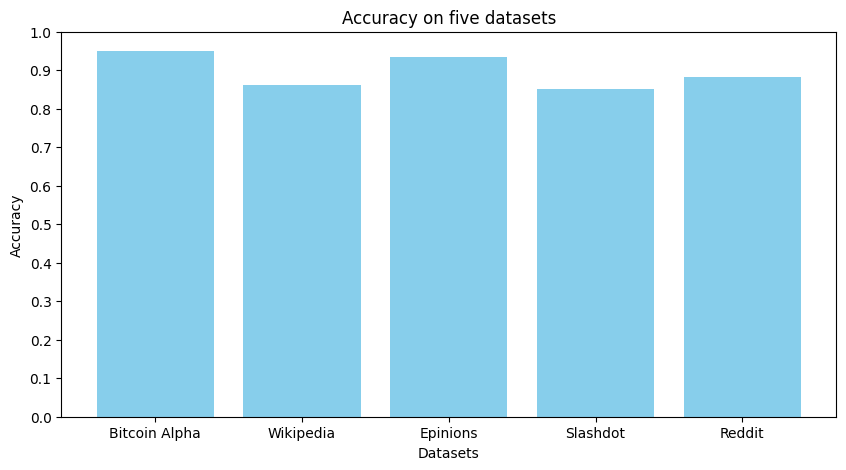

In [51]:
# plot the accuracy
plt.figure(figsize=(10, 5))
plt.bar(datasets, accuracy, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('Accuracy on five datasets')
plt.yticks([i / 10 for i in range(0, 11)])
plt.savefig('accuracy.png')
plt.show()

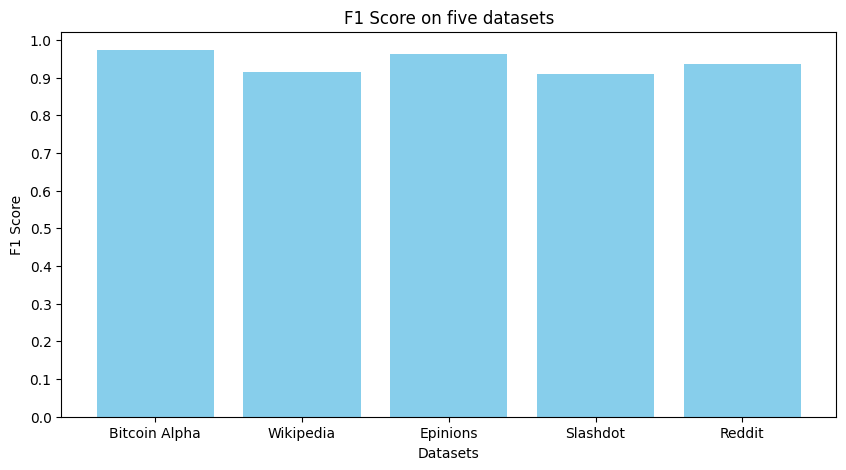

In [52]:
#plot the f1 score
plt.figure(figsize=(10, 5))
plt.bar(datasets, f1_score, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('F1 Score')
plt.title('F1 Score on five datasets')
plt.yticks([i / 10 for i in range(0, 11)])
plt.savefig('f1_score.png')
plt.show()